# Method 1 - Rest Ideas After 1

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Calculate Market Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 1].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

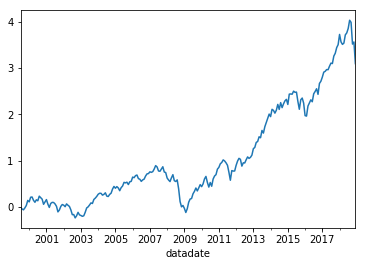

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.140779
2000-12-31   -0.031375
2001-12-31   -0.048326
2002-12-31   -0.212365
2003-12-31    0.480988
2004-12-31    0.175930
2005-12-31    0.075736
2006-12-31    0.108570
2007-12-31    0.012609
2008-12-31   -0.407843
2009-12-31    0.436299
2010-12-31    0.225658
2011-12-31   -0.021814
2012-12-31    0.192948
2013-12-31    0.417953
2014-12-31    0.106033
2015-12-31   -0.024518
2016-12-31    0.145618
2017-12-31    0.212767
2018-12-31   -0.091054
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2906.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.28e-195
Time:                        19:18:43   Log-Likelihood:                 833.54
No. Observations:                 234   AIC:                            -1657.
Df Residuals:                     229   BIC:                            -1640.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.711      0.000       0.001       0.003
mktrf          1.0152      0.013     78.419      0.000       0.990       1.041
me             0.2915      0.015     19.356      0.000       0.262       0.321
ia             0.0559      0.023      2.441      0.015       0.011       0.101
roe           -0.0711      0.020     -3.629      0.000      -0.110      -0.032
==============================================================================
Omnibus:                       26.428   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.567
Skew:                          -0.081   Prob(JB):                     9.92e-30
Kurtosis:                       6.698   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1639.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.48e-167
Time:                        19:18:43   Log-Likelihood:                 833.54
No. Observations:                 234   AIC:                            -1657.
Df Residuals:                     229   BIC:                            -1640.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.617      0.000       0.001       0.003
mktrf          1.0152      0.016     63.798      0.000       0.984       1.046
me             0.2915      0.023     12.688      0.000       0.246       0.337
ia             0.0559      0.045      1.231      0.218      -0.033       0.145
roe           -0.0711      0.029     -2.476      0.013      -0.127      -0.015
==============================================================================
Omnibus:                       26.428   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.567
Skew:                          -0.081   Prob(JB):                     9.92e-30
Kurtosis:                       6.698   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1990.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.50e-176
Time:                        19:18:43   Log-Likelihood:                 833.54
No. Observations:                 234   AIC:                            -1657.
Df Residuals:                     229   BIC:                            -1640.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.878      0.000       0.001       0.003
mktrf          1.0152      0.015     66.017      0.000       0.985       1.045
me             0.2915      0.022     13.237      0.000       0.248       0.335
ia             0.0559      0.047      1.190      0.234      -0.036       0.148
roe           -0.0711      0.032     -2.225      0.026      -0.134      -0.008
==============================================================================
Omnibus:                       26.428   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.567
Skew:                          -0.081   Prob(JB):                     9.92e-30
Kurtosis:                       6.698   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1936.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.60e-184
Time:                        19:18:43   Log-Likelihood:                 813.10
No. Observations:                 234   AIC:                            -1614.
Df Residuals:                     228   BIC:                            -1593.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.667      0.000       0.001       0.003
mktrf          1.0334      0.014     72.842      0.000       1.005       1.061
smb            0.3189      0.019     17.036      0.000       0.282       0.356
hml            0.0191      0.022      0.864      0.389      -0.024       0.063
rmw           -0.0427      0.025     -1.710      0.089      -0.092       0.006
cma            0.0553      0.032      1.742      0.083      -0.007       0.118
==============================================================================
Omnibus:                       27.567   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.262
Skew:                           0.095   Prob(JB):                     1.74e-32
Kurtosis:                       6.869   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1553.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.78e-174
Time:                        19:18:43   Log-Likelihood:                 813.10
No. Observations:                 234   AIC:                            -1614.
Df Residuals:                     228   BIC:                            -1593.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.451      0.001       0.001       0.003
mktrf          1.0334      0.017     59.596      0.000       0.999       1.067
smb            0.3189      0.024     13.353      0.000       0.272       0.366
hml            0.0191      0.049      0.388      0.698      -0.077       0.115
rmw           -0.0427      0.031     -1.364      0.172      -0.104       0.019
cma            0.0553      0.049      1.118      0.263      -0.042       0.152
==============================================================================
Omnibus:                       27.567   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.262
Skew:                           0.095   Prob(JB):                     1.74e-32
Kurtosis:                       6.869   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2089.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.44e-188
Time:                        19:18:43   Log-Likelihood:                 813.10
No. Observations:                 234   AIC:                            -1614.
Df Residuals:                     228   BIC:                            -1593.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.420      0.001       0.001       0.003
mktrf          1.0334      0.017     62.021      0.000       1.001       1.066
smb            0.3189      0.024     13.456      0.000       0.272       0.365
hml            0.0191      0.051      0.372      0.710      -0.081       0.119
rmw           -0.0427      0.034     -1.238      0.216      -0.110       0.025
cma            0.0553      0.048      1.158      0.247      -0.038       0.149
==============================================================================
Omnibus:                       27.567   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.262
Skew:                           0.095   Prob(JB):                     1.74e-32
Kurtosis:                       6.869   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2179.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.13e-181
Time:                        19:18:43   Log-Likelihood:                 800.61
No. Observations:                 234   AIC:                            -1591.
Df Residuals:                     229   BIC:                            -1574.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.808      0.000       0.001       0.003
mktrf          1.0286      0.014     74.968      0.000       1.002       1.056
smb            0.3232      0.017     18.870      0.000       0.289       0.357
hml            0.0855      0.017      5.023      0.000       0.052       0.119
umd           -0.0229      0.011     -2.051      0.041      -0.045      -0.001
==============================================================================
Omnibus:                       26.835   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.306
Skew:                           0.126   Prob(JB):                     6.85e-30
Kurtosis:                       6.703   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1790.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.03e-171
Time:                        19:18:43   Log-Likelihood:                 800.61
No. Observations:                 234   AIC:                            -1591.
Df Residuals:                     229   BIC:                            -1574.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.197      0.001       0.001       0.003
mktrf          1.0286      0.018     55.742      0.000       0.992       1.065
smb            0.3232      0.023     14.126      0.000       0.278       0.368
hml            0.0855      0.049      1.756      0.079      -0.010       0.181
umd           -0.0229      0.021     -1.097      0.272      -0.064       0.018
==============================================================================
Omnibus:                       26.835   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.306
Skew:                           0.126   Prob(JB):                     6.85e-30
Kurtosis:                       6.703   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2226.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.69e-182
Time:                        19:18:43   Log-Likelihood:                 800.61
No. Observations:                 234   AIC:                            -1591.
Df Residuals:                     229   BIC:                            -1574.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.166      0.002       0.001       0.003
mktrf          1.0286      0.016     65.192      0.000       0.998       1.059
smb            0.3232      0.024     13.603      0.000       0.277       0.370
hml            0.0855      0.054      1.591      0.112      -0.020       0.191
umd           -0.0229      0.017     -1.344      0.179      -0.056       0.011
==============================================================================
Omnibus:                       26.835   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.306
Skew:                           0.126   Prob(JB):                     6.85e-30
Kurtosis:                       6.703   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1283.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.26e-94
Time:                        19:18:43   Log-Likelihood:                 407.49
No. Observations:                 120   AIC:                            -805.0
Df Residuals:                     115   BIC:                            -791.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.697      0.000       0.001       0.004
mktrf          1.0193      0.021     47.736      0.000       0.977       1.062
me             0.2724      0.021     12.915      0.000       0.231       0.314
ia             0.0931      0.033      2.819      0.006       0.028       0.158
roe           -0.0720      0.029     -2.463      0.015      -0.130      -0.014
==============================================================================
Omnibus:                       10.472   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.663
Skew:                          -0.108   Prob(JB):                     2.67e-06
Kurtosis:                       5.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     917.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.28e-86
Time:                        19:18:43   Log-Likelihood:                 407.49
No. Observations:                 120   AIC:                            -805.0
Df Residuals:                     115   BIC:                            -791.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.647      0.000       0.001       0.005
mktrf          1.0193      0.027     37.561      0.000       0.966       1.072
me             0.2724      0.024     11.230      0.000       0.225       0.320
ia             0.0931      0.051      1.828      0.068      -0.007       0.193
roe           -0.0720      0.036     -2.026      0.043      -0.142      -0.002
==============================================================================
Omnibus:                       10.472   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.663
Skew:                          -0.108   Prob(JB):                     2.67e-06
Kurtosis:                       5.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1461.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-97
Time:                        19:18:43   Log-Likelihood:                 407.49
No. Observations:                 120   AIC:                            -805.0
Df Residuals:                     115   BIC:                            -791.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.735      0.000       0.001       0.004
mktrf          1.0193      0.024     42.934      0.000       0.973       1.066
me             0.2724      0.024     11.345      0.000       0.225       0.319
ia             0.0931      0.046      2.004      0.045       0.002       0.184
roe           -0.0720      0.038     -1.915      0.056      -0.146       0.002
==============================================================================
Omnibus:                       10.472   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.663
Skew:                          -0.108   Prob(JB):                     2.67e-06
Kurtosis:                       5.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     834.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.42e-88
Time:                        19:18:43   Log-Likelihood:                 395.85
No. Observations:                 120   AIC:                            -779.7
Df Residuals:                     114   BIC:                            -763.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.480      0.001       0.001       0.005
mktrf          1.0710      0.025     42.981      0.000       1.022       1.120
smb            0.3165      0.028     11.214      0.000       0.261       0.372
hml           -0.0075      0.035     -0.218      0.828      -0.076       0.061
rmw           -0.0079      0.041     -0.193      0.847      -0.089       0.073
cma            0.1212      0.045      2.712      0.008       0.033       0.210
==============================================================================
Omnibus:                       12.226   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               34.877
Skew:                          -0.116   Prob(JB):                     2.67e-08
Kurtosis:                       5.631   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     971.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.16e-91
Time:                        19:18:43   Log-Likelihood:                 395.85
No. Observations:                 120   AIC:                            -779.7
Df Residuals:                     114   BIC:                            -763.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.443      0.001       0.001       0.005
mktrf          1.0710      0.034     31.839      0.000       1.005       1.137
smb            0.3165      0.037      8.634      0.000       0.245       0.388
hml           -0.0075      0.080     -0.094      0.925      -0.165       0.150
rmw           -0.0079      0.063     -0.126      0.900      -0.130       0.115
cma            0.1212      0.059      2.041      0.041       0.005       0.238
==============================================================================
Omnibus:                       12.226   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               34.877
Skew:                          -0.116   Prob(JB):                     2.67e-08
Kurtosis:                       5.631   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1673.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.95e-105
Time:                        19:18:43   Log-Likelihood:                 395.85
No. Observations:                 120   AIC:                            -779.7
Df Residuals:                     114   BIC:                            -763.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.602      0.000       0.001       0.005
mktrf          1.0710      0.032     33.343      0.000       1.008       1.134
smb            0.3165      0.037      8.493      0.000       0.243       0.390
hml           -0.0075      0.086     -0.088      0.930      -0.176       0.160
rmw           -0.0079      0.069     -0.114      0.909      -0.143       0.127
cma            0.1212      0.057      2.139      0.032       0.010       0.232
==============================================================================
Omnibus:                       12.226   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               34.877
Skew:                          -0.116   Prob(JB):                     2.67e-08
Kurtosis:                       5.631   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     904.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.29e-86
Time:                        19:18:43   Log-Likelihood:                 387.04
No. Observations:                 120   AIC:                            -764.1
Df Residuals:                     115   BIC:                            -750.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.806      0.000       0.002       0.005
mktrf          1.0421      0.022     46.716      0.000       0.998       1.086
smb            0.3150      0.025     12.402      0.000       0.265       0.365
hml            0.1033      0.025      4.061      0.000       0.053       0.154
umd           -0.0196      0.016     -1.252      0.213      -0.051       0.011
==============================================================================
Omnibus:                       11.812   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               33.579
Skew:                          -0.057   Prob(JB):                     5.11e-08
Kurtosis:                       5.589   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1083.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.01e-90
Time:                        19:18:43   Log-Likelihood:                 387.04
No. Observations:                 120   AIC:                            -764.1
Df Residuals:                     115   BIC:                            -750.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.958      0.000       0.002       0.005
mktrf          1.0421      0.030     34.952      0.000       0.984       1.101
smb            0.3150      0.028     11.115      0.000       0.259       0.371
hml            0.1033      0.062      1.664      0.096      -0.018       0.225
umd           -0.0196      0.025     -0.787      0.431      -0.069       0.029
==============================================================================
Omnibus:                       11.812   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               33.579
Skew:                          -0.057   Prob(JB):                     5.11e-08
Kurtosis:                       5.589   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1529.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.15e-98
Time:                        19:18:43   Log-Likelihood:                 387.04
No. Observations:                 120   AIC:                            -764.1
Df Residuals:                     115   BIC:                            -750.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.223      0.000       0.002       0.005
mktrf          1.0421      0.023     44.765      0.000       0.996       1.088
smb            0.3150      0.030     10.640      0.000       0.257       0.373
hml            0.1033      0.067      1.536      0.125      -0.029       0.235
umd           -0.0196      0.020     -1.007      0.314      -0.058       0.019
==============================================================================
Omnibus:                       11.812   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               33.579
Skew:                          -0.057   Prob(JB):                     5.11e-08
Kurtosis:                       5.589   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2504.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.03e-106
Time:                        19:18:43   Log-Likelihood:                 456.45
No. Observations:                 114   AIC:                            -902.9
Df Residuals:                     109   BIC:                            -889.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.741      0.000       0.001       0.003
mktrf          1.0119      0.013     76.239      0.000       0.986       1.038
me             0.3320      0.020     16.202      0.000       0.291       0.373
ia            -0.0740      0.028     -2.603      0.011      -0.130      -0.018
roe           -0.1222      0.025     -4.893      0.000      -0.172      -0.073
==============================================================================
Omnibus:                        9.181   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.001
Skew:                          -0.639   Prob(JB):                       0.0111
Kurtosis:                       3.513   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4035.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.96e-117
Time:                        19:18:43   Log-Likelihood:                 456.45
No. Observations:                 114   AIC:                            -902.9
Df Residuals:                     109   BIC:                            -889.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.030      0.000       0.001       0.002
mktrf          1.0119      0.010     97.750      0.000       0.992       1.032
me             0.3320      0.016     20.544      0.000       0.300       0.364
ia            -0.0740      0.030     -2.478      0.013      -0.132      -0.015
roe           -0.1222      0.024     -5.052      0.000      -0.170      -0.075
==============================================================================
Omnibus:                        9.181   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.001
Skew:                          -0.639   Prob(JB):                       0.0111
Kurtosis:                       3.513   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4659.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.11e-121
Time:                        19:18:43   Log-Likelihood:                 456.45
No. Observations:                 114   AIC:                            -902.9
Df Residuals:                     109   BIC:                            -889.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.932      0.000       0.001       0.003
mktrf          1.0119      0.010    101.764      0.000       0.992       1.031
me             0.3320      0.016     20.663      0.000       0.301       0.364
ia            -0.0740      0.033     -2.274      0.023      -0.138      -0.010
roe           -0.1222      0.023     -5.409      0.000      -0.166      -0.078
==============================================================================
Omnibus:                        9.181   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.001
Skew:                          -0.639   Prob(JB):                       0.0111
Kurtosis:                       3.513   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2575.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.46e-110
Time:                        19:18:43   Log-Likelihood:                 471.15
No. Observations:                 114   AIC:                            -930.3
Df Residuals:                     108   BIC:                            -913.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.971      0.051    -4.4e-06       0.002
mktrf          1.0188      0.011     91.143      0.000       0.997       1.041
smb            0.3070      0.018     16.920      0.000       0.271       0.343
hml            0.0149      0.023      0.646      0.520      -0.031       0.061
rmw           -0.1809      0.028     -6.383      0.000      -0.237      -0.125
cma           -0.0971      0.036     -2.699      0.008      -0.168      -0.026
==============================================================================
Omnibus:                        9.891   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.847
Skew:                          -0.666   Prob(JB):                      0.00727
Kurtosis:                       3.545   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2827.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.92e-113
Time:                        19:18:43   Log-Likelihood:                 471.15
No. Observations:                 114   AIC:                            -930.3
Df Residuals:                     108   BIC:                            -913.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.942      0.052    -7.3e-06       0.002
mktrf          1.0188      0.009    107.634      0.000       1.000       1.037
smb            0.3070      0.016     19.320      0.000       0.276       0.338
hml            0.0149      0.019      0.792      0.429      -0.022       0.052
rmw           -0.1809      0.025     -7.133      0.000      -0.231      -0.131
cma           -0.0971      0.039     -2.504      0.012      -0.173      -0.021
==============================================================================
Omnibus:                        9.891   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.847
Skew:                          -0.666   Prob(JB):                      0.00727
Kurtosis:                       3.545   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     4412.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.18e-123
Time:                        19:18:43   Log-Likelihood:                 471.15
No. Observations:                 114   AIC:                            -930.3
Df Residuals:                     108   BIC:                            -913.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.789      0.074   -7.49e-05       0.002
mktrf          1.0188      0.008    126.490      0.000       1.003       1.035
smb            0.3070      0.015     20.677      0.000       0.278       0.336
hml            0.0149      0.018      0.822      0.411      -0.021       0.051
rmw           -0.1809      0.026     -6.943      0.000      -0.232      -0.130
cma           -0.0971      0.040     -2.438      0.015      -0.175      -0.019
==============================================================================
Omnibus:                        9.891   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.847
Skew:                          -0.666   Prob(JB):                      0.00727
Kurtosis:                       3.545   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2191.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.10e-103
Time:                        19:18:43   Log-Likelihood:                 448.91
No. Observations:                 114   AIC:                            -887.8
Df Residuals:                     109   BIC:                            -874.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.837      0.404      -0.001       0.001
mktrf          1.0316      0.013     76.765      0.000       1.005       1.058
smb            0.3488      0.021     16.646      0.000       0.307       0.390
hml            0.0071      0.022      0.330      0.742      -0.036       0.050
umd           -0.0375      0.016     -2.303      0.023      -0.070      -0.005
==============================================================================
Omnibus:                        4.228   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                3.604
Skew:                          -0.386   Prob(JB):                        0.165
Kurtosis:                       3.404   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1831.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.23e-99
Time:                        19:18:43   Log-Likelihood:                 448.91
No. Observations:                 114   AIC:                            -887.8
Df Residuals:                     109   BIC:                            -874.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.813      0.416      -0.001       0.001
mktrf          1.0316      0.014     75.174      0.000       1.005       1.058
smb            0.3488      0.019     18.715      0.000       0.312       0.385
hml            0.0071      0.020      0.359      0.719      -0.032       0.046
umd           -0.0375      0.013     -2.996      0.003      -0.062      -0.013
==============================================================================
Omnibus:                        4.228   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                3.604
Skew:                          -0.386   Prob(JB):                        0.165
Kurtosis:                       3.404   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3566.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.56e-114
Time:                        19:18:43   Log-Likelihood:                 448.91
No. Observations:                 114   AIC:                            -887.8
Df Residuals:                     109   BIC:                            -874.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.817      0.414      -0.001       0.001
mktrf          1.0316      0.013     80.715      0.000       1.007       1.057
smb            0.3488      0.014     24.604      0.000       0.321       0.377
hml            0.0071      0.017      0.423      0.673      -0.026       0.040
umd           -0.0375      0.012     -3.130      0.002      -0.061      -0.014
==============================================================================
Omnibus:                        4.228   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                3.604
Skew:                          -0.386   Prob(JB):                        0.165
Kurtosis:                       3.404   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""